# Assignment 3: learning by gradient descent
## Base code 

In [89]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randint
import types

In [2]:
# Load the data
xi = pd.read_csv("Data/xi.csv", delimiter=',', header=None)
tau = pd.read_csv("Data/tau.csv", delimiter=',', header=None)
D = (xi, tau) # xi = 50x5000-dim array, tau = 1x5000-dim vector with target values

In [3]:
# Implementation of a shallow feed-forward neural network
def feed_forward_nn(weight_matrix, xi):
    # weight_matrix = [w1, w2, ..., wk]
    # xi = input vector of N-dim
    # vk = 1 for k = 1,...,K
    (Ndim, Kdim) = weight_matrix.shape
    vk = np.ones(shape=(Kdim, 1))
    sigma = 0
    for k in range(Kdim):
        wk = weight_matrix[:, k]
        sigma += vk[k] * np.tanh(np.dot(wk, xi))
    return sigma

In [4]:
# Evaluation metrics
def cost_function(weight_matrix, P, Q, Dataset):
    # Computes the cost function of E (0:P examples) and E_test (P+1:P+1+Q examples)
    E_train = 0
    for mu in range(P):
        xi_mu = Dataset[0][mu]; tau_mu = Dataset[1][mu]
        sigma_mu = feed_forward_nn(weight_matrix, xi_mu)
        E_train += (sigma_mu - tau_mu)**2
    E_train /= (2*P)
    
    E_test = 0
    for mu in range(Q):
        mu_t = P + mu
        xi_mu = Dataset[0][mu_t]; tau_mu = Dataset[1][mu_t]
        sigma_mu = feed_forward_nn(weight_matrix, xi_mu)
        E_test += (sigma_mu - tau_mu)**2
    E_test /= (2*Q)
    
    return E_train, E_test

In [97]:
# Training of the neural network
def train_feed_forward_nn(Dataset, K, P, Q, t_max, eta=0.05, verbose=False):
    N_dim = len(Dataset[0][0])
    
    # Weights initialization. Each w_k vector is independently generated from the others, and should have a norm 1.
    # The v_k weights are fixed to 1, not being updated during training
    W = np.zeros(shape=(N_dim, K)); v = np.ones(shape=(K, 1))
    for k in range(K):
        w_k = rand(N_dim)
        W[:, k] = w_k / np.sqrt(np.dot(w_k, w_k)) 
    
    E_train = []; E_test = []
    for t_i in range(t_max):
        nu_vector = randint(0, P, size=P) # gets a random vector with values between 0 and P
        
        if verbose: print('# Step {} out of {}'.format(t_i + 1, t_max))
        
        if isinstance(eta, types.FunctionType):
            eta_val = eta(t_i)
        else:
            eta_val = eta
        
        for nu in nu_vector: 
            xi_nu = Dataset[0][nu]; tau_nu = Dataset[1][nu]
            sigma_nu = feed_forward_nn(W, xi_nu)
            
            diff = (sigma_nu - tau_nu) 
            for k in range(K): # updates each weight vector w_k
                w_k = W[:, k]
                grad_e_k = float(diff * v[k] * (1 - np.tanh(np.dot(w_k, xi_nu))**2)) * xi_nu
                w_k -= eta_val * grad_e_k
                W[:, k] = w_k
                
        # After performing P updates, the costs are estimated
        E_tr, E_ts = cost_function(W, P, Q, Dataset)
        E_train.append(E_tr); E_test.append(E_ts)
    
    return (W, v), (E_train, E_test)


In [6]:
# Testing of the neural network
K = 2; P = 100; Q = 200; t_max = 50; eta=0.05
(W, v), (E_train, E_test) = train_feed_forward_nn(D, K, P, Q, t_max, eta)      

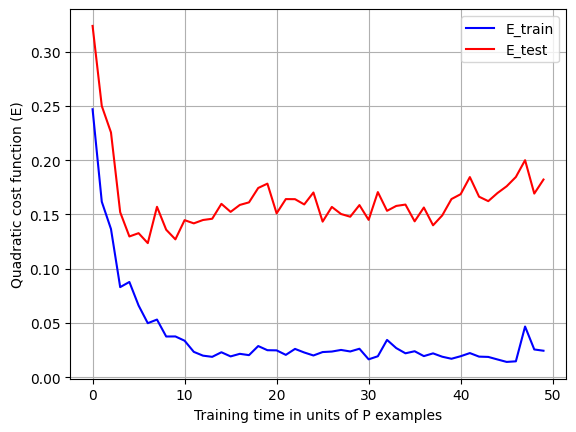

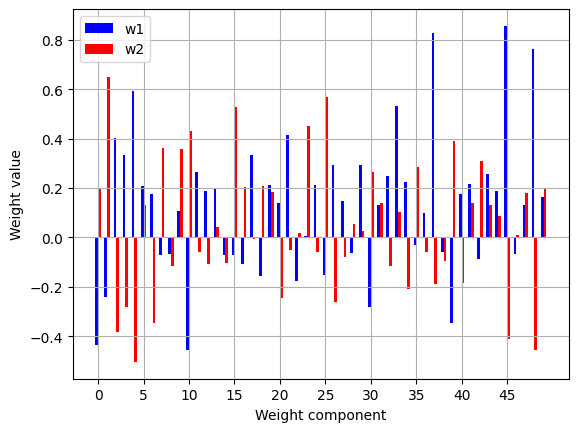

In [7]:
# Plot the final trained weight vectors and the evolution of the cost functions
def plot_costs(weight_matrix, E_train, E_test, save_path=""):
    N_dim = len(weight_matrix[:, 0]); t_max = len(E_train)
    
    t = range(t_max)
    plt.plot(t, E_train, label='E_train', color='b')
    plt.plot(t, E_test, label='E_test', color='r')
    plt.xlabel('Training time in units of P examples')
    plt.ylabel('Quadratic cost function (E)')
    plt.grid()
    plt.legend()
    plt.show()
    
    if len(save_path) > 2: plt.savefig(save_path)
    
def plot_weights(weight_matrix, bin_width=0.3, save_path=""):
    N_dim = len(weight_matrix[:, 0])


    x = np.array(range(N_dim))
    plt.bar(x - bin_width / 2, weight_matrix[:,0], width=bin_width, color='blue', label='w1')
    plt.bar(x + bin_width / 2, weight_matrix[:,1], width=bin_width, color='red', label='w2')
    plt.xlabel('Weight component')
    plt.ylabel('Weight value')
    plt.xticks(range(0, N_dim, 5))
    plt.grid()
    plt.legend()
    if len(save_path) > 2: plt.savefig(save_path)

np.save("Data/e_train_e_test.npy", (E_train, E_test))
plot_costs(W, E_train, E_test, "Data/cost_evolution.png")

np.save("Data/weight_matrix.npy", W)
plot_weights(W, save_path="Data/weights.png")
 

### Bonus point 1 
The following values of P are considered: {20, 50, 200, 500, 1000, 2000}
For each value of P, Q = 2*P examples for test are considered
1. The evolution of the cost function is obtained for each P
2. The right stopping time is selected accordingly to their evolutions
3. The final training and test errors are plotted as an evolution of P

In [20]:
# Testing of the neural network - First the evolution of the cost
P_values = (20, 50, 100, 200, 500, 1000, 2000)
t_values = (15, 15, 20, 20, 20, 20, 20)

K = 2; eta=0.05
final_E_train = []; final_E_test = []

for (P_val, t_val) in zip(P_values, t_values):
    print("P_val: {} out of {}".format(P_values.index(P_val) + 1, len(P_values)))
    Q_val = 2*P_val 
    if (P_val + Q_val) > 5000:
        Q_val = 5000 - P_val
    (W_v, v_v), (E_train_v, E_test_v) = train_feed_forward_nn(D, K, P_val, Q_val, t_val, eta, verbose=False) 
    final_E_train.append(E_train_v[-1]); final_E_test.append(E_test_v[-1])
    
    # plot_costs(W_v, E_train_v, E_test_v, "Data_bonus/Bonus1/P_{}.png".format(P_val))


P_val: 1 out of 7
P_val: 2 out of 7
P_val: 3 out of 7
P_val: 4 out of 7
P_val: 5 out of 7
P_val: 6 out of 7
P_val: 7 out of 7


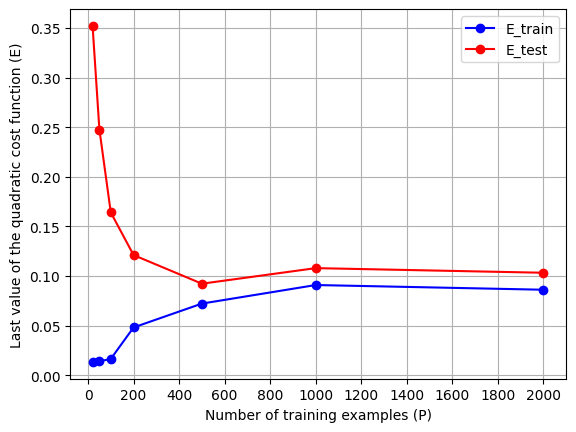

<Figure size 640x480 with 0 Axes>

In [26]:
plt.plot(P_values, final_E_train, 'bo-', label='E_train')
plt.plot(P_values, final_E_test, 'ro-', label='E_test')
plt.xlabel('Number of training examples (P)')
plt.ylabel('Last value of the quadratic cost function (E)')
plt.grid()
plt.xticks(range(0, 2001, 200))
plt.legend()
plt.show()

np.save("Data_bonus/Bonus1/final_e.npy", (final_E_train, final_E_test))
plt.savefig("Data_bonus/Bonus1/final_e.png")

### Bonus point 2
Study the influence of the learning parameter eta. Different values for the learning rate are analysed and compared: {0.05, 0.1, 0.2, 0.5, 1}. Also, a time-dependent policy is studied: eta(t) = 1 / (1 + t)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


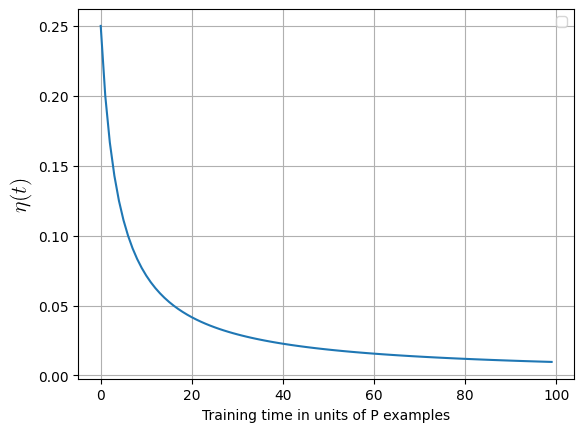

In [103]:
# Time-dependant policy of the learning rate
def eta_l(t, a=1, b=4):
    return a / (b + t)

times = range(0, 100)
etas = [eta_l(tt) for tt in times]
plt.plot(times, etas)
plt.xlabel('Training time in units of P examples')
plt.ylabel('$\eta(t)$', usetex=1, fontsize=16)
plt.grid()
# plt.xticks(range(0, 2001, 200))
plt.legend()


np.save("Data_bonus/Bonus2/eta_t.npy", (times, etas))
plt.savefig("Data_bonus/Bonus2/policy_eta.png")

In [100]:
eta_values = [0.05, 0.1, 0.2, 0.5, 1, eta_l]
K = 2; P = 100; Q = 200; t_max = 30

E_train_eta = []; E_test_eta = []

for eta_v in eta_values:
    print("Eta_it: {} out of {}".format(eta_values.index(eta_v) + 1, len(eta_values)))
    (W, v), (E_train, E_test) = train_feed_forward_nn(D, K, P, Q, t_max, eta_v)  
    E_train_eta.append(E_train); E_test_eta.append(E_test)
    

Eta_it: 1 out of 6
Eta_it: 2 out of 6
Eta_it: 3 out of 6
Eta_it: 4 out of 6
Eta_it: 5 out of 6
Eta_it: 6 out of 6


<Figure size 640x480 with 0 Axes>

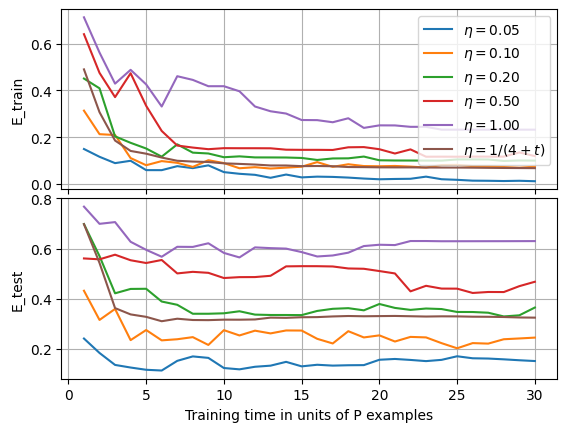

In [111]:
plt.clf()
fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

labels = []
for ii in range(len(eta_values) - 1):
    labels.append('$\eta={:.2f}$'.format(eta_values[ii]))
labels.append('$\eta=1/(4 + t)$')

for ii in range(len(E_train_eta)):
    ax1.plot(range(1, t_max+1), E_train_eta[ii], label=labels[ii])
    ax2.plot(range(1, t_max+1), E_test_eta[ii], label=labels[ii])
    
plt.subplots_adjust(hspace=.05)
# plt.plot(t, E_test, label='E_test', color='r')
ax1.set_xlabel('')
ax1.set_ylabel('E_train')


ax2.set_xlabel('Training time in units of P examples')
ax2.set_ylabel('E_test')

ax1.grid('minor', which='both')
ax2.grid('minor', 'both')
ax1.legend(loc='upper right')

np.save("Data_bonus/Bonus2/evolutions.npy", (E_train_eta, E_test_eta))
plt.savefig("Data_bonus/Bonus2/evolutions.png")